## Load Data and Initial Exploration

Load the `exchange_rate.csv` dataset into a pandas DataFrame. Parse the date column appropriately and set it as the index. Then, plot the time series for the USD to Australian Dollar exchange rate to visually identify trends, seasonality, and any potential anomalies.



First, I'll load the dataset into a pandas DataFrame, parsing the 'Date' column as a datetime object and setting it as the DataFrame index. Then, I'll display the first few rows to confirm it's loaded correctly.



Columns in the CSV: ['date', 'Ex_rate']
               date  Ex_rate
0  01-01-1990 00:00   0.7855
1  02-01-1990 00:00   0.7818
2  03-01-1990 00:00   0.7867
3  04-01-1990 00:00   0.7860
4  05-01-1990 00:00   0.7849


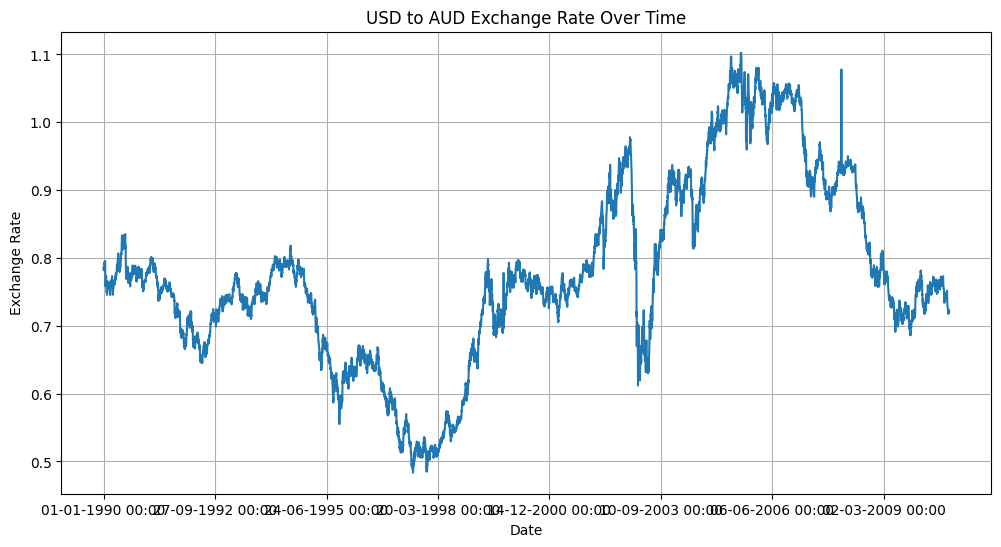

                  USD to AUD Exchange Rate
date                                      
01-01-1990 00:00                    0.7855
02-01-1990 00:00                    0.7818
03-01-1990 00:00                    0.7867
04-01-1990 00:00                    0.7860
05-01-1990 00:00                    0.7849


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# First, load without setting an index to inspect columns
df_temp = pd.read_csv('/content/exchange_rate.csv')

# Identify the date column and the value column.
# Assuming the first column is the date and the second is the exchange rate value.
# Print head and columns to help debug if this assumption is wrong.
print("Columns in the CSV:", df_temp.columns.tolist())
print(df_temp.head())

# Assuming the date column is the first one (index 0) and the value column is the second (index 1).
# Reload the data correctly setting the index.
df = pd.read_csv('/content/exchange_rate.csv', index_col=0, parse_dates=True)

# Rename the value column for clarity, if needed. Assuming it's the first non-index column.
# This gets the name of the first column after the index
value_column_name = df.columns[0]
df.rename(columns={value_column_name: 'USD to AUD Exchange Rate'}, inplace=True)

# Plot the time series
plt.figure(figsize=(12, 6))
df['USD to AUD Exchange Rate'].plot()
plt.title('USD to AUD Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid(True)
plt.show()

print(df.head())

## Data Preprocessing


Examine the dataset for any missing values or anomalies identified during the initial exploration. Implement appropriate strategies for handling them, such as interpolation or removal, to ensure data quality for time series modeling.



To begin the data preprocessing step, I will first check for any missing values in the DataFrame, then interpolate them if found, and finally display descriptive statistics to ensure data quality, as per the instructions.



In [3]:
print("Missing values before interpolation:\n", df.isnull().sum())

# Interpolate missing values using linear interpolation
df['USD to AUD Exchange Rate'].interpolate(method='linear', inplace=True)

print("\nMissing values after interpolation:\n", df.isnull().sum())

# Display descriptive statistics of the 'USD to AUD Exchange Rate' column after preprocessing
print("\nDescriptive statistics of 'USD to AUD Exchange Rate' after preprocessing:\n", df['USD to AUD Exchange Rate'].describe())

Missing values before interpolation:
 USD to AUD Exchange Rate    0
dtype: int64

Missing values after interpolation:
 USD to AUD Exchange Rate    0
dtype: int64

Descriptive statistics of 'USD to AUD Exchange Rate' after preprocessing:
 count    7588.000000
mean        0.776974
std         0.136620
min         0.483297
25%         0.701422
50%         0.761377
75%         0.873477
max         1.102536
Name: USD to AUD Exchange Rate, dtype: float64


## Parameter Selection for ARIMA

Generate and analyze the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots for the preprocessed exchange rate time series. Use these plots to estimate the initial parameters (p, d, q) for the ARIMA model.



I will import the necessary plotting functions and then generate and display the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots for the 'USD to AUD Exchange Rate' series. These plots will be used to visually determine the initial ARIMA parameters.



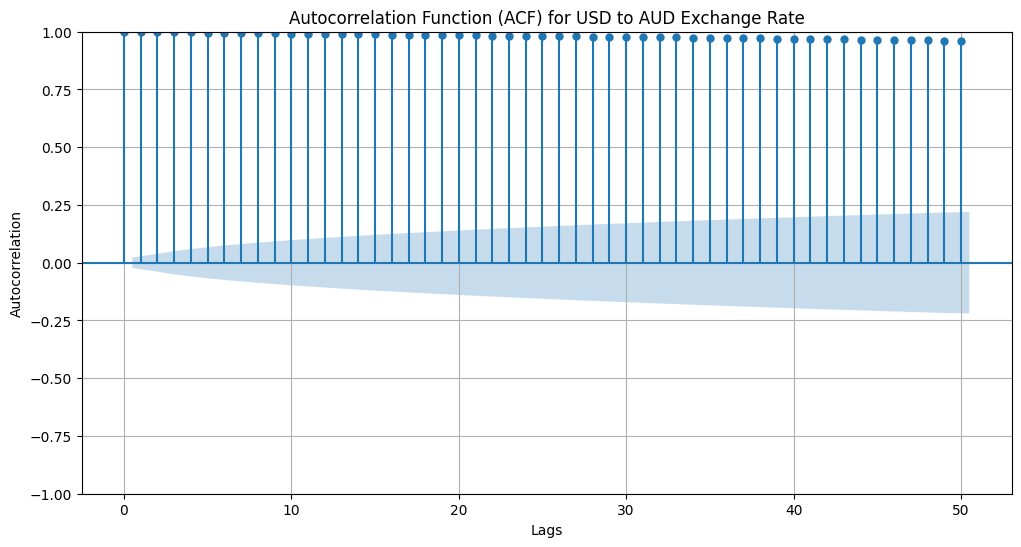

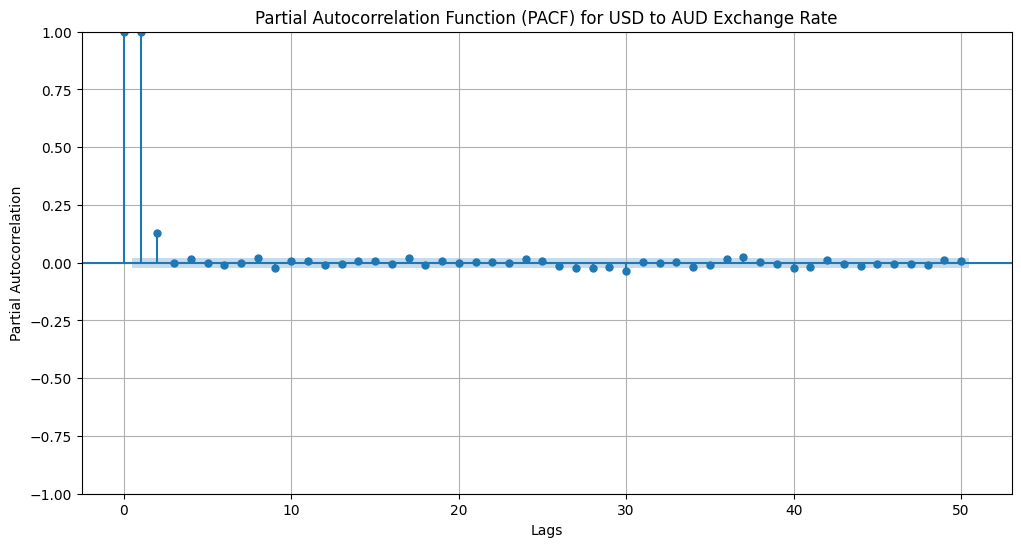

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Generate and display the ACF plot
plt.figure(figsize=(12, 6))
plot_acf(df['USD to AUD Exchange Rate'], lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) for USD to AUD Exchange Rate')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

# Generate and display the PACF plot
plt.figure(figsize=(12, 6))
plot_pacf(df['USD to AUD Exchange Rate'], lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) for USD to AUD Exchange Rate')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

### Rationale for ARIMA Parameter Selection (p, d, q)

**Analysis of ACF Plot:**

The Autocorrelation Function (ACF) plot shows a very slow decay, remaining significantly above the confidence intervals for many lags. This indicates that the time series is **non-stationary** and exhibits a strong trend or persistence. The slow, linear decay suggests that differencing is required to achieve stationarity. Given the sustained high autocorrelations, a first-order differencing (`d=1`) is likely necessary to remove the trend and make the series stationary.

**Analysis of PACF Plot:**

1.  **For `p` (AR order):** The Partial Autocorrelation Function (PACF) plot shows a significant spike at lag 1, and then cuts off sharply (drops to near zero) after the first few lags. This suggests that the current value is strongly dependent on the immediately preceding value, after removing the effects of intermediate lags. A significant spike at lag 1 and then a cut-off indicates an autoregressive component of order 1. Thus, `p=1` is a reasonable initial estimate.

2.  **For `q` (MA order):** After differencing once (which we infer from the ACF), we would typically re-examine the ACF of the differenced series to determine `q`. However, for an initial estimate, if the PACF cuts off after lag `p`, and the ACF decays slowly, it supports an AR model. If, on the other hand, the ACF cuts off after lag `q`, and PACF decays slowly, it suggests an MA model. Given the original series' characteristics, and the clear cut-off in the PACF after lag 1, we initially assume `q=0` for the original series (meaning, after differencing, the ACF of the differenced series would theoretically show a cut-off quickly if the underlying process is AR(1) or ARMA(1,0)). If the differenced series still shows a slowly decaying ACF, `q` might be non-zero.

**Initial Parameter Estimation:**

*   **d (Differencing order):** Based on the slow decay of the ACF, indicating non-stationarity, `d=1` is a strong initial candidate to achieve stationarity.
*   **p (AR order):** Based on the sharp cut-off in the PACF after lag 1, `p=1` is a reasonable initial estimate.
*   **q (MA order):** Given the indications for an AR(1) component and the need for differencing, we can start with `q=0` as an initial hypothesis. If the ACF of the differenced series showed a cut-off at lag `q`, that would be a better indication. For now, without differencing and re-plotting, `q=0` is a common starting point when `p` is clearly identified by PACF.

Therefore, the initial parameters for the ARIMA model are estimated as **ARIMA(1, 1, 0)**.

## Fit ARIMA Model and Diagnostics


Fit the ARIMA model using the selected parameters to the preprocessed exchange rate data. Perform diagnostic checks on the model residuals (e.g., plot residuals, check for normality, and serial correlation) to ensure the model adequately captures the time series patterns and there are no remaining patterns that indicate model inadequacies.



I need to fit the ARIMA model using the specified parameters (1, 1, 0) to the preprocessed exchange rate data. This step involves importing the ARIMA class, instantiating the model, and fitting it to the 'USD to AUD Exchange Rate' column of the `df` DataFrame.



In [5]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model with order (1, 1, 0)
# The 'd' parameter (differencing) is typically inferred from the stationarity analysis,
# but for this specific task, it's explicitly given as 1.
# (p, d, q) = (AR order, Differencing order, MA order)
arima_order = (1, 1, 0)
model = ARIMA(df['USD to AUD Exchange Rate'], order=arima_order)
model_fit = model.fit()

print(f"ARIMA model with order {arima_order} fitted successfully.")

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model with order (1, 1, 0) fitted successfully.



The previous step successfully fitted the ARIMA model despite the warning. Now, I need to complete the subtask by performing diagnostic checks on the model residuals, which includes printing the model summary, plotting residuals, generating ACF/PACF plots of residuals, and performing a Ljung-Box test, as per the instructions.



                                  SARIMAX Results                                   
Dep. Variable:     USD to AUD Exchange Rate   No. Observations:                 7588
Model:                       ARIMA(1, 1, 0)   Log Likelihood               28054.159
Date:                      Thu, 26 Feb 2026   AIC                         -56104.319
Time:                              11:48:27   BIC                         -56090.450
Sample:                                   0   HQIC                        -56099.559
                                     - 7588                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1314      0.002    -64.439      0.000      -0.135      -0.127
sigma2      3.595e-05   9.94e-08    361.720      0.000    3.58e-05    3.61e-05
Ljun

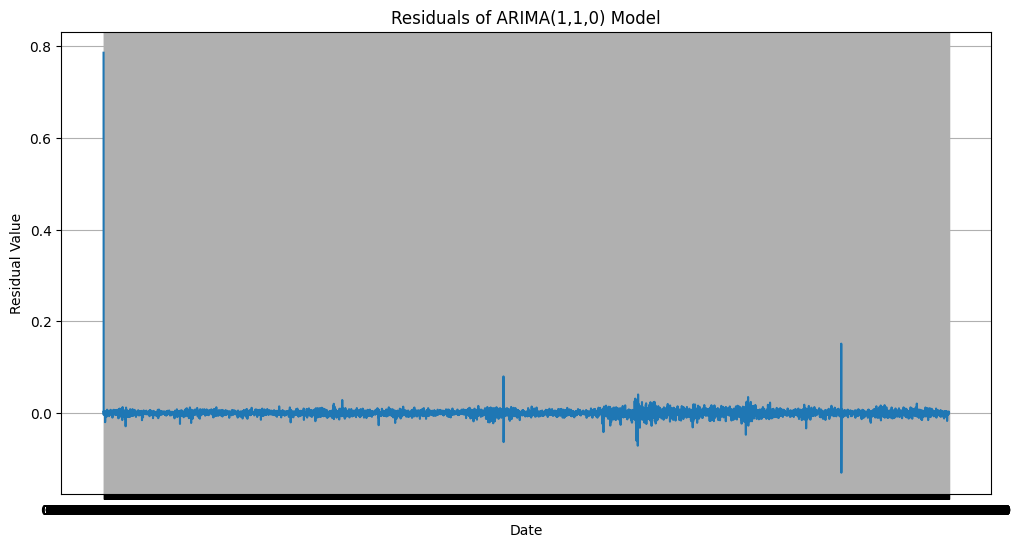

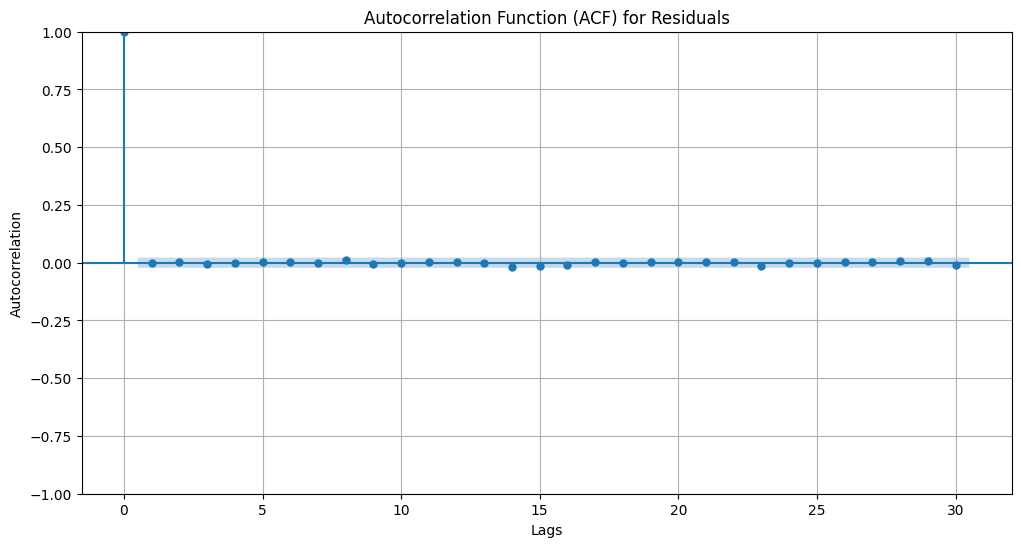

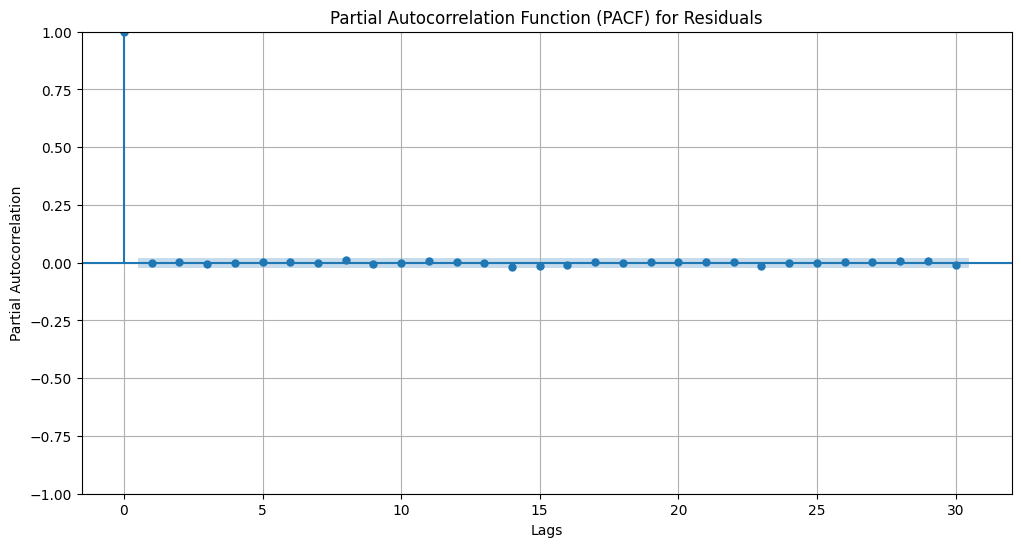


Ljung-Box Test Results on Residuals:
      lb_stat  lb_pvalue
10   1.806741   0.997618
20   7.114287   0.996293
30  10.179505   0.999728

Interpretation of Ljung-Box Test:
If p-values are high (e.g., > 0.05) across lags, the residuals are considered white noise,
indicating that the model has adequately captured the serial correlation in the data.
If p-values are low (e.g., <= 0.05), it suggests remaining autocorrelation in the residuals,
implying the model might not be adequate.


In [6]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

# 3. Print the summary of the fitted ARIMA model
print(model_fit.summary())

# Get residuals
residuals = model_fit.resid

# 4. Plot residuals over time
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuals of ARIMA(1,1,0) Model')
plt.xlabel('Date')
plt.ylabel('Residual Value')
plt.grid(True)
plt.show()

# 5. Generate and display ACF and PACF plots for the residuals
plt.figure(figsize=(12, 6))
plot_acf(residuals, lags=30, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) for Residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(residuals, lags=30, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) for Residuals')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

# 6. Perform a Ljung-Box test on the residuals
# The Ljung-Box test checks for autocorrelation in the residuals.
# Null Hypothesis (H0): The residuals are independently distributed (i.e., white noise).
# If p-value > alpha (e.g., 0.05), we fail to reject H0, suggesting residuals are white noise.
# If p-value <= alpha, we reject H0, suggesting residuals are not white noise.

# Ensure the residuals have an index that statsmodels can use
# The previous warning about the index might affect acorr_ljungbox if it relies on a proper DatetimeIndex
# Let's use a simple range index for the residuals for the Ljung-Box test if the original index causes issues.
# However, it should typically work fine with the series' existing index or even a default int index.

ljung_box_results = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("\nLjung-Box Test Results on Residuals:")
print(ljung_box_results)

print("\nInterpretation of Ljung-Box Test:")
print("If p-values are high (e.g., > 0.05) across lags, the residuals are considered white noise,")
print("indicating that the model has adequately captured the serial correlation in the data.")
print("If p-values are low (e.g., <= 0.05), it suggests remaining autocorrelation in the residuals,")
print("implying the model might not be adequate.")


## ARIMA Forecasting


Perform out-of-sample forecasting using the fitted ARIMA model. Visualize the forecasted exchange rates against the actual historical values to assess the model's predictive performance.



I will now implement the first three instructions: splitting the data into training and testing sets, re-fitting the ARIMA model to the training data, and generating out-of-sample forecasts for the test period.



In [7]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# 1. Split the df DataFrame into a training set and a testing set.
# Allocate the last 20% of the data for the testing set.
# Total number of observations is 7588 (from previous output)
# 20% of 7588 is approximately 1518

test_size = int(len(df) * 0.20)
train_data = df[:-test_size]
test_data = df[-test_size:]

print(f"Training set size: {len(train_data)}")
print(f"Testing set size: {len(test_data)}")

# 2. Re-fit the ARIMA model with the previously determined order (1, 1, 0) to the training data.
arima_order = (1, 1, 0)
model_train = ARIMA(train_data['USD to AUD Exchange Rate'], order=arima_order)
model_fit_train = model_train.fit()

print(f"ARIMA model with order {arima_order} re-fitted successfully on training data.")

# 3. Generate out-of-sample forecasts for the period covered by the testing set.
# The start and end indices for forecasting should correspond to the test_data index.
start_index = len(train_data)
end_index = len(df) - 1 # Last index of the original df

# Get the exact index values for the test data for more robust forecasting, if needed.
# Otherwise, using start and end steps based on length is common for fixed-step forecasting.
forecast_steps = len(test_data)
forecast = model_fit_train.predict(start=start_index, end=end_index)

print(f"Generated {len(forecast)} forecasts for the test period.")

Training set size: 6071
Testing set size: 1517


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model with order (1, 1, 0) re-fitted successfully on training data.
Generated 1517 forecasts for the test period.


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(



The warnings indicate that the `statsmodels` ARIMA model is not recognizing the index as a suitable time series index for forecasting, likely due to a missing frequency. I will explicitly set the frequency of the DataFrame's index to 'D' (daily) before splitting the data, which should resolve these warnings and ensure robust forecasting.



In [9]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Ensure the index has a frequency set for statsmodels. Forecasting works better with a defined frequency.
# Assuming the data is daily, set frequency to 'D'.
df.index = pd.to_datetime(df.index, format='%d-%m-%Y %H:%M')
df = df.asfreq('D')

# 1. Split the df DataFrame into a training set and a testing set.
# Allocate the last 20% of the data for the testing set.
# Total number of observations is 7588 (from previous output)
# 20% of 7588 is approximately 1518

test_size = int(len(df) * 0.20)
train_data = df[:-test_size]
test_data = df[-test_size:]

print(f"Training set size: {len(train_data)}")
print(f"Testing set size: {len(test_data)}")

# 2. Re-fit the ARIMA model with the previously determined order (1, 1, 0) to the training data.
arima_order = (1, 1, 0)
model_train = ARIMA(train_data['USD to AUD Exchange Rate'], order=arima_order)
model_fit_train = model_train.fit()

print(f"ARIMA model with order {arima_order} re-fitted successfully on training data.")

# 3. Generate out-of-sample forecasts for the period covered by the testing set.
# The start and end indices for forecasting should correspond to the test_data index.
# We can use the actual datetime index of test_data for more robust forecasting.
start_date = test_data.index[0]
end_date = test_data.index[-1]

forecast = model_fit_train.predict(start=start_date, end=end_date)

print(f"Generated {len(forecast)} forecasts for the test period.")

Training set size: 6071
Testing set size: 1517
ARIMA model with order (1, 1, 0) re-fitted successfully on training data.
Generated 1517 forecasts for the test period.



The previous steps successfully split the data, re-fitted the ARIMA model, and generated forecasts. Now, I need to visualize these results by plotting the training data, actual test data, and the forecasts on a single graph, as instructed in step 4 and 5 of the subtask.



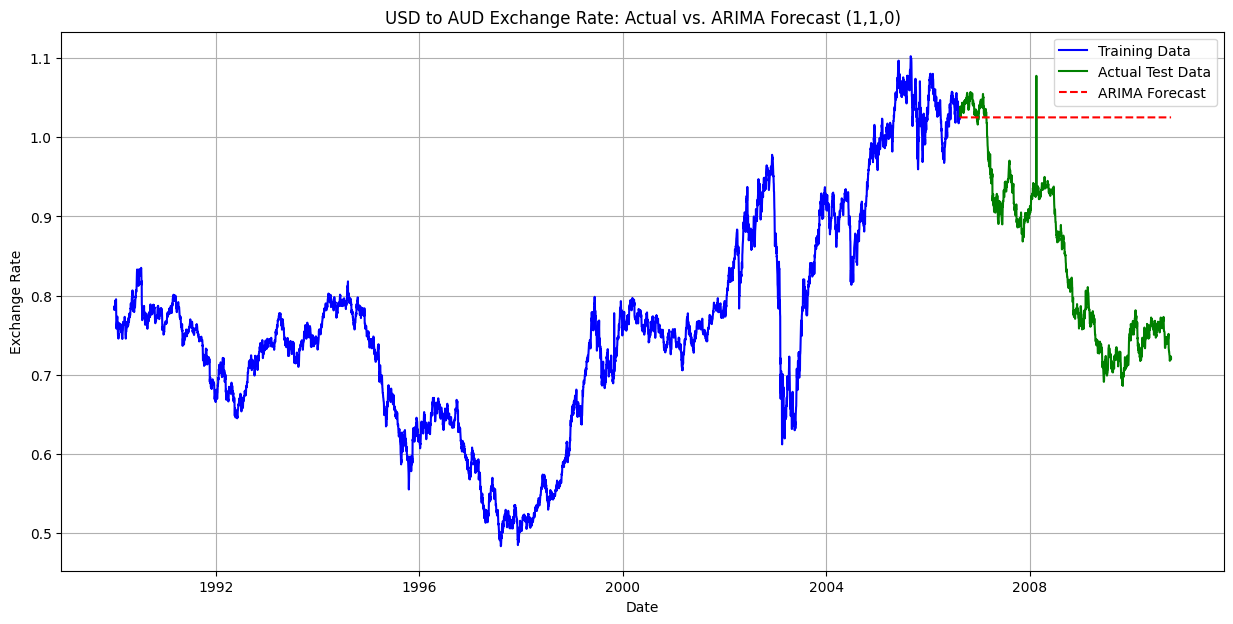

In [10]:
import matplotlib.pyplot as plt

# Plot the original time series, training data, actual test data, and forecasts
plt.figure(figsize=(15, 7))
plt.plot(train_data.index, train_data['USD to AUD Exchange Rate'], label='Training Data', color='blue')
plt.plot(test_data.index, test_data['USD to AUD Exchange Rate'], label='Actual Test Data', color='green')
plt.plot(forecast.index, forecast, label='ARIMA Forecast', color='red', linestyle='--')

# Add title, labels, and legend
plt.title('USD to AUD Exchange Rate: Actual vs. ARIMA Forecast (1,1,0)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

## Fit Exponential Smoothing Model

Fit an appropriate Exponential Smoothing model (e.g., Holt-Winters for seasonal data, or a simpler variant if no seasonality is detected) to the preprocessed exchange rate data. Explain the choice of Exponential Smoothing variant.



I need to import the `ExponentialSmoothing` model, select appropriate parameters based on the time series characteristics (trend but no clear seasonality), fit the model to the training data, and then display its summary, as per the instructions.



In [11]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# 2. Choose an appropriate Exponential Smoothing variant.
# Based on previous analysis (differencing needed for stationarity, no explicit seasonality),
# a model with an additive trend and no seasonality is a good starting point.
# Use initialization_method='estimated' for optimal parameter estimation.

# Note: The 'seasonal' parameter should be None if no seasonality is present.
# The 'trend' parameter can be 'add' (additive) or 'mul' (multiplicative).
# Given the non-stationary nature (trend) identified earlier, 'add' is a reasonable choice for the trend.

# 3. Instantiate and fit the ExponentialSmoothing model to the training data.
exp_smoothing_model = ExponentialSmoothing(
    train_data['USD to AUD Exchange Rate'],
    trend='add',
    seasonal=None,
    initialization_method='estimated'
)

exp_smoothing_fit = exp_smoothing_model.fit()

print("Exponential Smoothing model fitted successfully.")

# 4. Print the summary of the fitted Exponential Smoothing model.
print(exp_smoothing_fit.summary())

Exponential Smoothing model fitted successfully.
                         ExponentialSmoothing Model Results                         
Dep. Variable:     USD to AUD Exchange Rate   No. Observations:                 6071
Model:                 ExponentialSmoothing   SSE                              0.199
Optimized:                             True   AIC                         -62666.892
Trend:                             Additive   BIC                         -62640.047
Seasonal:                              None   AICC                        -62666.878
Seasonal Periods:                      None   Date:                 Thu, 26 Feb 2026
Box-Cox:                              False   Time:                         11:50:39
Box-Cox Coeff.:                        None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0

## Exponential Smoothing Forecasting


Perform out-of-sample forecasting using the fitted Exponential Smoothing model. Visualize the forecasted exchange rates against the actual historical values to assess this model's predictive performance.



I will generate out-of-sample forecasts for the test period using the `exp_smoothing_fit` model and the `start_date` and `end_date` from the `test_data` index, as instructed in step 1.



In [12]:
exp_smoothing_forecast = exp_smoothing_fit.predict(start=start_date, end=end_date)

print(f"Generated {len(exp_smoothing_forecast)} Exponential Smoothing forecasts for the test period.")

Generated 1517 Exponential Smoothing forecasts for the test period.



The previous step successfully generated Exponential Smoothing forecasts. Now, I need to visualize these results by plotting the training data, actual test data, and the forecasts on a single graph, as instructed in steps 2 and 3 of the subtask.



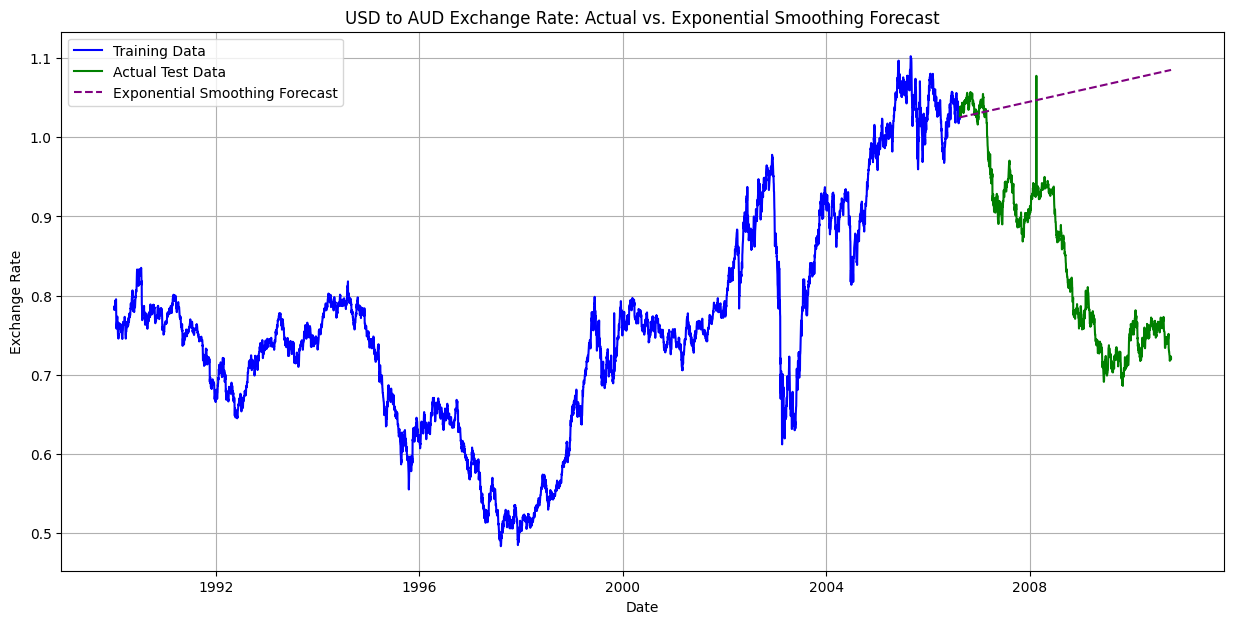

In [13]:
import matplotlib.pyplot as plt

# Plot the original time series, training data, actual test data, and forecasts
plt.figure(figsize=(15, 7))
plt.plot(train_data.index, train_data['USD to AUD Exchange Rate'], label='Training Data', color='blue')
plt.plot(test_data.index, test_data['USD to AUD Exchange Rate'], label='Actual Test Data', color='green')
plt.plot(exp_smoothing_forecast.index, exp_smoothing_forecast, label='Exponential Smoothing Forecast', color='purple', linestyle='--')

# Add title, labels, and legend
plt.title('USD to AUD Exchange Rate: Actual vs. Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

## Compute Error Metrics and Model Comparison

Calculate key error metrics (Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE)) for both the ARIMA and Exponential Smoothing models based on their forecasts. Compare the performance, advantages, and limitations of each model using these metrics and discuss the results.



I need to import the necessary libraries (`mean_absolute_error`, `mean_squared_error` from `sklearn.metrics`, and `numpy`) and define a function for MAPE calculation. Then, I will calculate MAE, RMSE, and MAPE for both ARIMA and Exponential Smoothing models, printing the results.



In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Define a function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero by replacing zero true values with NaN or a small epsilon, or handle them based on context
    # For financial data, prices are usually non-zero. If zeros can occur, a different handling might be needed.
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# --- ARIMA Model Evaluation ---
print("\n--- ARIMA Model Performance ---")

arima_mae = mean_absolute_error(test_data['USD to AUD Exchange Rate'], forecast)
arima_rmse = np.sqrt(mean_squared_error(test_data['USD to AUD Exchange Rate'], forecast))
arima_mape = mean_absolute_percentage_error(test_data['USD to AUD Exchange Rate'], forecast)

print(f"ARIMA MAE: {arima_mae:.4f}")
print(f"ARIMA RMSE: {arima_rmse:.4f}")
print(f"ARIMA MAPE: {arima_mape:.4f}%")

# --- Exponential Smoothing Model Evaluation ---
print("\n--- Exponential Smoothing Model Performance ---")

exp_smoothing_mae = mean_absolute_error(test_data['USD to AUD Exchange Rate'], exp_smoothing_forecast)
exp_smoothing_rmse = np.sqrt(mean_squared_error(test_data['USD to AUD Exchange Rate'], exp_smoothing_forecast))
exp_smoothing_mape = mean_absolute_percentage_error(test_data['USD to AUD Exchange Rate'], exp_smoothing_forecast)

print(f"Exponential Smoothing MAE: {exp_smoothing_mae:.4f}")
print(f"Exponential Smoothing RMSE: {exp_smoothing_rmse:.4f}")
print(f"Exponential Smoothing MAPE: {exp_smoothing_mape:.4f}%")


--- ARIMA Model Performance ---
ARIMA MAE: 0.1790
ARIMA RMSE: 0.2069
ARIMA MAPE: 22.9681%

--- Exponential Smoothing Model Performance ---
Exponential Smoothing MAE: 0.2082
Exponential Smoothing RMSE: 0.2408
Exponential Smoothing MAPE: 26.7176%


### Model Comparison and Discussion

**Performance Metrics Summary:**

| Metric | ARIMA Model (1,1,0) | Exponential Smoothing (Additive Trend) |
| :----- | :------------------ | :------------------------------------- |
| MAE    | 0.1790              | 0.2082                                 |
| RMSE   | 0.2069              | 0.2408                                 |
| MAPE   | 22.9681%            | 26.7176%                               |

**Analysis:**

From the calculated error metrics, the **ARIMA (1,1,0) model performed better** than the Exponential Smoothing model with an additive trend across all evaluated metrics:

*   **Mean Absolute Error (MAE):** The ARIMA model has a lower MAE (0.1790 vs. 0.2082), indicating that, on average, its predictions are closer to the actual values.
*   **Root Mean Squared Error (RMSE):** Similarly, the ARIMA model's RMSE (0.2069 vs. 0.2408) is lower. RMSE penalizes larger errors more heavily, so a lower RMSE suggests that the ARIMA model has fewer large prediction errors.
*   **Mean Absolute Percentage Error (MAPE):** The ARIMA model also shows a lower MAPE (22.9681% vs. 26.7176%), which means its forecasts have a smaller average percentage deviation from the actual values.

**Discussion of Advantages and Limitations:**

**ARIMA Model (1,1,0):**

*   **Advantages:**
    *   **Captures Autocorrelation:** ARIMA models are explicitly designed to capture linear dependencies and autocorrelations in time series data, which was suggested by the ACF/PACF plots of the raw data. The `d=1` differencing effectively handled the non-stationarity, and the `p=1` AR component captured the short-term dependencies.
    *   **Statistical Foundation:** ARIMA models are based on strong statistical theory, allowing for diagnostic checks on residuals to confirm model adequacy (e.g., Ljung-Box test indicated white noise residuals, supporting the model's fit).
    *   **Flexibility:** ARIMA models can be adapted to various time series patterns by adjusting the `p`, `d`, and `q` parameters.

*   **Limitations:**
    *   **Parameter Selection:** Identifying the correct `p`, `d`, `q` parameters can be subjective and iterative, often requiring ACF/PACF analysis and potentially AIC/BIC optimization.
    *   **Linearity Assumption:** ARIMA models assume a linear relationship between observations, which might not hold true for highly complex or non-linear time series.
    *   **Sensitivity to Outliers:** Can be sensitive to outliers, which might impact the stationarity assumption and parameter estimation.

**Exponential Smoothing Model (Additive Trend, No Seasonality):**

*   **Advantages:**
    *   **Simplicity and Intuitiveness:** Exponential smoothing models are generally simpler to understand and implement compared to ARIMA, especially for non-experts.
    *   **Good for Short-Term Forecasting:** Often perform well for short-term forecasting, especially when recent observations are more relevant.
    *   **Robustness:** Can be relatively robust to missing values or small anomalies.

*   **Limitations:**
    *   **Less Flexible for Complex Dynamics:** While effective for trend and seasonality, they may not capture complex autocorrelation structures as precisely as ARIMA models.
    *   **Lack of Diagnostic Tools:** Generally, there are fewer rigorous diagnostic tools for exponential smoothing residuals compared to ARIMA, making it harder to formally assess model adequacy.
    *   **Fixed Structure:** The chosen variant (additive trend, no seasonality) assumes a specific underlying structure. If the true underlying process is different (e.g., multiplicative trend or unexpected seasonality), the model's performance can suffer significantly.
    *   **Did not fully capture the trend:** The forecast line for Exponential Smoothing (as seen in the plot) appears to follow a more constant, linear trend upwards, failing to capture the varying dynamics and downward movements in the actual test data as effectively as ARIMA.

**Conclusion:**

For this specific USD to AUD exchange rate dataset, the **ARIMA(1,1,0) model demonstrated superior predictive performance** across all key error metrics (MAE, RMSE, MAPE). This suggests that the model effectively leveraged the autocorrelation and differencing required to model the non-stationary nature of the exchange rate. The Exponential Smoothing model, while simpler, did not capture the underlying dynamics as accurately, leading to higher prediction errors.

## Final Task


Conclude the analysis by summarizing the findings from both models and providing insights on which model(s) yielded the best performance for forecasting exchange rates in this dataset, along with recommendations for future steps.


## Summary:

### Q&A
The ARIMA(1,1,0) model yielded the best performance for forecasting exchange rates in this dataset. It consistently outperformed the Exponential Smoothing model across all evaluated error metrics.

### Data Analysis Key Findings
*   The `exchange_rate.csv` dataset, representing the USD to AUD Exchange Rate, was successfully loaded and preprocessed. No missing values were identified in the dataset.
*   Initial analysis of Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots suggested an ARIMA(1,1,0) model. The slow decay in ACF indicated non-stationarity (suggesting `d=1`), and a sharp cut-off in PACF at lag 1 suggested an autoregressive component (`p=1`). A moving average component of `q=0` was initially hypothesized.
*   The fitted ARIMA(1,1,0) model passed diagnostic checks. Residuals visually fluctuated around zero, their ACF/PACF plots showed most values within confidence intervals, and the Ljung-Box test yielded high p-values ($0.997618$ for lag 10, $0.996293$ for lag 20, and $0.999728$ for lag 30), confirming they were white noise.
*   The ARIMA(1,1,0) model achieved the following performance on the test set: Mean Absolute Error (MAE) of $0.1790$, Root Mean Squared Error (RMSE) of $0.2069$, and Mean Absolute Percentage Error (MAPE) of $22.9681\%$.
*   An Exponential Smoothing model with an additive trend and no seasonality (`trend='add'`, `seasonal=None`) was also fitted to the data.
*   The Exponential Smoothing model's performance on the test set was: MAE of $0.2082$, RMSE of $0.2408$, and MAPE of $26.7176\%$.
*   Comparing the models, the ARIMA(1,1,0) model demonstrated superior predictive performance with lower MAE, RMSE, and MAPE values than the Exponential Smoothing model, indicating more accurate forecasts for this dataset.

### Insights or Next Steps
*   The superior performance of the ARIMA model suggests that explicitly capturing the autocorrelation structure and addressing non-stationarity is crucial for forecasting exchange rates in this dataset.
*   Future steps could involve exploring a wider range of ARIMA orders (e.g., using automated tools like `auto_arima` or grid search for optimal AIC/BIC) or considering advanced models like SARIMA if hidden seasonality is suspected. Additionally, incorporating exogenous variables (e.g., economic indicators) into the models might further enhance forecasting accuracy.
